# Setup

In [1]:
DATA_VERSION = "2025-07-14"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
DOCUMENT_EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)
CONSULTATION_EMBEDDINGS_FILE_NAME = (
    f"consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)


LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    # "openparldata",
    # "organisation_rule",
    "manual",
}

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40

_approximate_topic_f1_scores = {
    "administration": 0.602,
    "agriculture": 0.811,
    "communications": 0.742,
    "culture": 0.596,
    "defense": 0.704,
    "economics": 0.555,
    "education": 0.832,
    "energy": 0.872,
    "environment": 0.805,
    "finance": 0.673,
    "foreign_policy": 0.659,
    "health": 0.818,
    "housing": 0.804,
    "insurance": 0.834,
    "it": 0.727,
    "law": 0.523,
    "migration": 0.885,
    "political_system": 0.857,
    "public_finance": 0.72,
    "science": 0.6,
    "security": 0.57,
    "social": 0.558,
    "spatial_planning": 0.643,
    "transportation": 0.865,
}

IGNORE_TOPICS = {
    # t for t, f1 in _approximate_topic_f1_scores.items() if f1 < 0.7
}

DOC_TYPES = {
    "DRAFT",
    # None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    # "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271

In [2]:
%load_ext autoreload
%autoreload 2

import functools
import pathlib
import sys
from typing import Any

import dotenv
import iterstrat.ml_stratifiers
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.consultation_topics.preprocessing
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_consultation_topic_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("document_embeddings_file", DOCUMENT_EMBEDDINGS_FILE_NAME)
mlflow.log_param("consultation_embeddings_file", CONSULTATION_EMBEDDINGS_FILE_NAME)
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = brawny-crane-117


''

In [5]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/07/21 10:24:13 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [6]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)
DOCUMENT_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DOCUMENT_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(DOCUMENT_EMBEDDINGS_DATA_FILE)
CONSULTATION_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / CONSULTATION_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(CONSULTATION_EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-14.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-07-14.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-2025-07-14.parquet already exists locally.


In [7]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
9,1CAJoURQbi5gxw7Wp5N5rT,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfmiLy7uCJJK4xiJ4o,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
21,1CAJoURregQSBjKq3Pp2mL,a49pncfq,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]","[{'created_at': 2025-01-27 11:30:14, 'name': '...",...,Bundesamt für Kommunikation,ch,1CM3wg6vz2uQ3oZqEQcf7s,fedlex,manual,fedlex,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...,2024/2/22/1CM3wg6vjrx6u67JD8PayD.pdf,application/pdf,8fb68017e53055498c277ed8afe60d56ee2935aa
24,1CAJoURregQSBjKq3bkcQG,a49pncfq,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]","[{'created_at': 2025-01-27 11:30:14, 'name': '...",...,Bundesamt für Kommunikation,ch,1CM3wg91WFEgcbEEu47R61,fedlex,manual,fedlex,1 \n \n \n \nEidgenössisches Departement für U...,2024/2/25/1CM3wg8zFnPR7BBwyJk3i6.pdf,application/pdf,1675bfe0112b243840e5214c0ae5c2b656f6f8b1
42,1CAJoUSHBj4qdYJPe3PFcd,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgUgRrjEFontegfgyd,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/43/1CM3wgUcDxsq2yKqdZsaGe.pdf,application/pdf,98a60f2d0b0b0ce18b5ce82a1e9df248c3629bb9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53986,1CQXzKTntXV3vrQjD2LXDg,jh9ctnan,2025-06-25,2025-10-16,Verordnungspaket Umwelt Frühling 2026,"Anpassung von Verordnungen des Umweltrechts, n...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/jh9ctnan,"[economics, environment]","[{'created_at': 2025-06-30 09:36:50, 'name': '...",...,Bundesamt für Umwelt,ch,1CQdqahNbNiCt2JY43Ts8v,fedlex,manual,fedlex,BAFU-D-63FE3401/1610\nEidgenössisches Departem...,2025/5175/55988/1CQdqahN6ie2cDF6Q73bWr.pdf,application/pdf,a64faa7208d5f22834c4118085350e4af5dcf0de
53992,1CQXzKTo8ZpCz7CbxUYMHv,jh9ctnan,2025-06-25,2025-10-16,Verordnungspaket Umwelt Frü

In [8]:
df_document_embeddings = pd.read_parquet(DOCUMENT_EMBEDDINGS_DATA_FILE)
df_document_embeddings

,embedding
document_uuid,
1CAJoURQMxKeqCdQ4jLniS,"[0.01030252780765295, -0.014312159270048141, -..."
1CAJoURQMxKeqCdQ4vhCQx,"[0.011395552195608616, 0.0014780974015593529, ..."
1CAJoURQMxKeqCdQ564eYH,"[-0.005767590366303921, 0.002646328415721655, ..."
1CAJoURQbi5gxw7Wp5N5rT,"[0.019797369837760925, -0.00907826703041792, -..."
1CAJoURQbi5gxw7WpL8ns1,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
1CQq2cR8RAR9368nVmJotB,"[0.006463687866926193, 0.0037266802974045277, ..."
1CQq2cR8RAR9368nVrayp9,"[0.013085871003568172, -0.010078459046781063, ..."
1CQzVcZwRMubJVL3zmzPPX,"[0.011624314822256565, -0.030158638954162598, ..."


In [9]:
df_consultation_embeddings = pd.read_parquet(CONSULTATION_EMBEDDINGS_DATA_FILE)
df_consultation_embeddings = df_consultation_embeddings[
    df_consultation_embeddings.index.get_level_values("attribute_language").isin(LANGUAGES)
]
df_consultation_embeddings

,,,text,embedding
consultation_identifier,attribute_language,attribute_name,,
222gq6cs,de,consultation_title,Gesetz über die Ausbildungsbeiträge (Stipendie...,"[-0.006880167871713638, 0.02503645420074463, -..."
2259wqvq,de,consultation_title,Revision der Asylverordnung 2 über Finanzierun...,"[0.019555626437067986, 0.038168445229530334, -..."
22acxr55,de,consultation_title,Evaluation Kindes- und Erwachsenenschutzrecht ...,"[-0.024509185925126076, 0.01123279333114624, -..."
22fcru5x,de,consultation_title,Revision der Verordnung 2 zum Arbeitsgesetz (A...,"[0.01675618812441826, 0.023464420810341835, -0..."
22mkgk7j,de,consultation_title,Änderung der Verordnung über die CO2-Abgabe (C...,"[-0.0014414963079616427, -0.00654450012370944,..."
...,...,...,...,...
zzy2ettp,de,organisation_name,Regierungsrat des Kantons Aargau,"[0.029343530535697937, -0.008861028589308262, ..."
a9j4assx,de,consultation_description,Primär soll die landwirtschaftliche Beratung a...,"[0.014760013669729233, 0.00452077342197299, -0..."
qju8bcrr,de,consultation_description,Die Spitalplanung ist regelmässig zu überprüfe...,"[-0.023545196279883385, 0.030222192406654358, ..."


## Create the input dataframe

In [10]:
df_docs_embeddings = df_docs.join(df_document_embeddings, on="document_uuid", how="inner").rename(
    columns={"embedding": "embedding_documents"}
)

df_consultations = df_docs_embeddings.groupby("consultation_identifier").agg(
    {
        **dict.fromkeys(
            [
                "consultation_start_date",
                "consultation_end_date",
                "consultation_title",
                "consultation_description",
                "consultation_url",
                "consultation_topics",
                "organisation_uuid",
                "organisation_name",
                "political_body",
            ],
            "first",
        ),
        "embedding_documents": "mean",
        "document_content_plain": "\n\f".join,
    }
)


def get_embeddings_by_attribute(df: pd.DataFrame, attribute_name: str) -> pd.Series:
    idx = df.index.get_level_values("attribute_name") == attribute_name
    series = df[idx].reset_index(["attribute_language", "attribute_name"], drop=True)["embedding"]
    series.name = f"embedding_{attribute_name}"
    return series


df_consultations = df_consultations.join(
    get_embeddings_by_attribute(df_consultation_embeddings, "consultation_title"),
    on="consultation_identifier",
)

df_consultations = df_consultations.join(
    get_embeddings_by_attribute(df_consultation_embeddings, "consultation_description"),
    on="consultation_identifier",
)

assert df_consultations.notna().any().any()
df_consultations

,consultation_start_date,consultation_end_date,consultation_title,consultation_description,consultation_url,consultation_topics,organisation_uuid,organisation_name,political_body,embedding_documents,document_content_plain,embedding_consultation_title,embedding_consultation_description
consultation_identifier,,,,,,,,,,,,,
2259wqvq,2024-06-14,2024-10-05,Revision der Asylverordnung 2 über Finanzierun...,"Die Vernehmlassungsvorlage regelt, dass bei ei...",https://www.demokratis.ch/vernehmlassung/2259wqvq,"[migration, public_finance]",1CAJoUHHCnfz9o2Sk7mKcM,Staatssekretariat für Migration,ch,"[0.0027769748121500015, 0.002668623346835375, ...",«$$e-seal» \n«$$QrCode» \n \n2024-... \n«%ASFF...,"[0.019555626437067986, 0.038168445229530334, -...","[-0.009512459859251976, 0.03718934953212738, -..."
22mkgk7j,2009-10-28,2009-11-30,Änderung der Verordnung über die CO2-Abgabe (C...,Am 12. Juni 2009 hat das Parlament einer Teilr...,https://www.demokratis.ch/vernehmlassung/22mkgk7j,"[energy, environment, housing, public_finance]",1CAJoTm1JXgoKwQzXusunF,Bundesamt für Umwelt,ch,"[0.003618871094658971, -0.02058025635778904, -...",2009–1799 \n1 \nVerordnung \nüber die CO2-Abga...,"[-0.0014414963079616427, -0.00654450012370944,...","[0.01454092562198639, -0.010943349450826645, -..."
22rhfj95,2021-10-01,2022-01-17,Änderung der Verordnung über die Bekämpfung de...,Am 19. März 2021 hat das Parlament diverse Mas...,https://www.demokratis.ch/vernehmlassung/22rhfj95,"[finance, foreign_policy, security]",1CAJoUJoj5aoqnqArNWPj7,Staatssekretariat für internationale Finanzfragen,ch,"[0.011960811680182815, -0.017195088788866997, ...",[Signature] \n[QR Code] \n2021-…\nVerordnung ...,"[-0.021519239991903305, 0.02354583516716957, 0...","[0.006501497235149145, 0.033047761768102646, -..."
254aynz4,2024-06-26,2024-10-17,Änderung des Elektrizitätsgesetzes (Beschleuni...,Um den Aus- und Umbau der Stromnetze zu beschl...,https://www.demokratis.ch/vernehmlassung/254aynz4,[energy],1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.0011703572236001492, -0.01821432914584875,...",«$$e-seal»\n«$$QrCode»\n2024-...\n«%ASFF_YYYY_...,"[-0.006315543316304684, 0.019167453050613403, ...","[0.020425185561180115, -0.012738894671201706, ..."
26j4aved,2015-11-18,2016-02-05,Anhörung zur Änderung der Energieverordnung (EnV),Im Rahmen der geplanten Änderung der Energieve...,https://www.demokratis.ch/vernehmlassung/26j4aved,"[energy, environment, public_finance]",1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.014478437602519989, 0.001966044306755066, ...",1 \nEnergieverordnung \n(EnV) \nÄnderung vom …...,"[-0.0011688020313158631, -0.009328276850283146...","[-0.013965312391519547, -0.0033353467006236315..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygt9epc,2023-03-10,2023-06-19,Teilrevision des Strahlenschutzgesetzes (StSG),Mit der Teilrevision des Strahlenschutzgesetze...,https://www.demokratis.ch/vernehmlassung/zygt9epc,"[energy, health, security]",1CAJoTnFCtJnsD3wTA3Hbh,Bundesamt für Gesundheit,ch,"[0.013696594629436731, -0.020180982071906328, ...",«$$e-seal» \n«$$QrCode» \n \n2022-… \n«%ASFF_Y...,"[0.02344311773777008, -0.0019313521916046739, ...","[0.003862101584672928, 0.001099311513826251, -..."
zyuux9us,2020-08-13,2020-11-13,Fischereigesetz,Der Regierungsrat des Kantons Thurgau hat das ...,https://www.demokratis.ch/vernehmlassung/zyuux9us,"[agriculture, environment, social]",1CAJp8R2qUWAjU4jUg1wpg,Regierungsrat des Kantons Thurgau,tg,"[0.0028271819464862347, -0.024680876173079014,...","Departement für Justiz und Sicherheit \n4, \nT...","[0.03620738536119461, 0.007286127656698227, 0....","[0.011934221722185612, 0.005627253092825413, -..."
zzby35xf,2010-02-04,2010-03-31,08.520 Parlamentarische Initiative. Abschaffun...,Im Vorentwurf zur Änderung des Strassenverkehr...,https://www.demokratis.ch/vernehmlassung/zzby35xf,"[insurance, sports, transportation]",1CAJoTk5j878QEmvteGGTw,Bundesamt für Strassen,ch,"[-0.0006106528453528881, -0.006748750107362866...",2002–.

In [11]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.encode_topics(df_consultations)
print(topic_columns)
df_input

['topic_administration', 'topic_agriculture', 'topic_communications', 'topic_culture', 'topic_defense', 'topic_economics', 'topic_education', 'topic_energy', 'topic_environment', 'topic_finance', 'topic_foreign_policy', 'topic_health', 'topic_housing', 'topic_insurance', 'topic_it', 'topic_law', 'topic_media', 'topic_migration', 'topic_political_system', 'topic_public_finance', 'topic_science', 'topic_security', 'topic_social', 'topic_spatial_planning', 'topic_sports', 'topic_transportation']


,consultation_start_date,consultation_end_date,consultation_title,consultation_description,consultation_url,consultation_topics,organisation_uuid,organisation_name,political_body,embedding_documents,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
consultation_identifier,,,,,,,,,,,,,,,,,,,,,
2259wqvq,2024-06-14,2024-10-05,Revision der Asylverordnung 2 über Finanzierun...,"Die Vernehmlassungsvorlage regelt, dass bei ei...",https://www.demokratis.ch/vernehmlassung/2259wqvq,"[migration, public_finance]",1CAJoUHHCnfz9o2Sk7mKcM,Staatssekretariat für Migration,ch,"[0.0027769748121500015, 0.002668623346835375, ...",...,0,1,0,1,0,0,0,0,0,0
22mkgk7j,2009-10-28,2009-11-30,Änderung der Verordnung über die CO2-Abgabe (C...,Am 12. Juni 2009 hat das Parlament einer Teilr...,https://www.demokratis.ch/vernehmlassung/22mkgk7j,"[energy, environment, housing, public_finance]",1CAJoTm1JXgoKwQzXusunF,Bundesamt für Umwelt,ch,"[0.003618871094658971, -0.02058025635778904, -...",...,0,0,0,1,0,0,0,0,0,0
22rhfj95,2021-10-01,2022-01-17,Änderung der Verordnung über die Bekämpfung de...,Am 19. März 2021 hat das Parlament diverse Mas...,https://www.demokratis.ch/vernehmlassung/22rhfj95,"[finance, foreign_policy, security]",1CAJoUJoj5aoqnqArNWPj7,Staatssekretariat für internationale Finanzfragen,ch,"[0.011960811680182815, -0.017195088788866997, ...",...,0,0,0,0,0,1,0,0,0,0
254aynz4,2024-06-26,2024-10-17,Änderung des Elektrizitätsgesetzes (Beschleuni...,Um den Aus- und Umbau der Stromnetze zu beschl...,https://www.demokratis.ch/vernehmlassung/254aynz4,[energy],1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.0011703572236001492, -0.01821432914584875,...",...,0,0,0,0,0,0,0,0,0,0
26j4aved,2015-11-18,2016-02-05,Anhörung zur Änderung der Energieverordnung (EnV),Im Rahmen der geplanten Änderung der Energieve...,https://www.demokratis.ch/vernehmlassung/26j4aved,"[energy, environment, public_finance]",1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.014478437602519989, 0.001966044306755066, ...",...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygt9epc,2023-03-10,2023-06-19,Teilrevision des Strahlenschutzgesetzes (StSG),Mit der Teilrevision des Strahlenschutzgesetze...,https://www.demokratis.ch/vernehmlassung/zygt9epc,"[energy, health, security]",1CAJoTnFCtJnsD3wTA3Hbh,Bundesamt für Gesundheit,ch,"[0.013696594629436731, -0.020180982071906328, ...",...,0,0,0,0,0,1,0,0,0,0
zyuux9us,2020-08-13,2020-11-13,Fischereigesetz,Der Regierungsrat des Kantons Thurgau hat das ...,https://www.demokratis.ch/vernehmlassung/zyuux9us,"[agriculture, environment, social]",1CAJp8R2qUWAjU4jUg1wpg,Regierungsrat des Kantons Thurgau,tg,"[0.0028271819464862347, -0.024680876173079014,...",...,0,0,0,0,0,0,1,0,0,0
zzby35xf,2010-02-04,2010-03-31,08.520 Parlamentarische Initiative. Abschaffun...,Im Vorentwurf zur Änderung des Strassenverkehr...,https://www.demokratis.ch/vernehmlassung/zzby35xf,"[insurance, sports, transportation]",1CAJoTk5j878QEmvteGGTw,Bundesamt für Strassen,ch,"[-0.0006106528453528881, -0.006748750107362866...",...,0,0,0,0,0,0,0,0,1,1


## Drop underrepresented topics

In [12]:
from collections.abc import Iterable

# TODO: refactor and merge into preprocessing.drop_underrepresented_topics


def drop_underrepresented_topics(
    df: pd.DataFrame,
    topic_columns: Iterable[str],
    min_consultations_in_class: int,
    *,
    always_drop_topics: Iterable[str] = (),
) -> tuple[pd.DataFrame, list[str]]:
    # Drop columns
    always_drop_topics = {t if t.startswith("topic_") else f"topic_{t}" for t in always_drop_topics}
    if always_drop_topics - set(topic_columns):
        raise ValueError(
            "The following topics are not present in the input data", always_drop_topics - set(topic_columns)
        )
    consultations_per_topic = df[topic_columns].sum(axis=0).sort_values(ascending=False)
    to_drop = consultations_per_topic[
        (consultations_per_topic < min_consultations_in_class)
        | (consultations_per_topic.index.isin(always_drop_topics))
    ]
    print("Dropping these underrepresented classes:", to_drop, sep="\n")
    df = df.drop(columns=to_drop.index)
    topic_columns = [c for c in topic_columns if c not in to_drop.index]
    # Drop rows that no longer have any labels
    samples_without_label = df[topic_columns].sum(axis=1) == 0
    print(
        "Dropping these samples without any label:",
        len(df[samples_without_label]),
    )
    df = df[~samples_without_label]

    return df, topic_columns


df_input, topic_columns = drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
topic_sports    38
topic_media     12
dtype: int64
Dropping these samples without any label: 0


In [13]:
print("Original number of documents:", df_docs.shape[0])
print("Original number of consultations:", df_docs["consultation_identifier"].nunique())
print("\ndf_input size (consultations):", df_input.shape[0])
print("classes (topics):", len(topic_columns))

Original number of documents: 2953
Original number of consultations: 1224

df_input size (consultations): 1222
classes (topics): 24


## Add extra features

In [14]:
KEYWORD_FEATURES = {
    "contains_" + "|".join(or_keywords): or_keywords
    for or_keywords in (
        # topic_security
        ("sicherheit", "polizei", "stgb"),
        # topic_social
        ("ehegatten", "kindes", "kinder"),
        # topic_spatial_planning
        ("anlagen", "bauzonen", "wohnungen"),
    )
}

mlflow.log_param("keyword_features", sorted(KEYWORD_FEATURES.keys()))


def add_features(df: pd.DataFrame, keyword_features: dict[str, tuple[str, ...]]) -> pd.DataFrame:
    df = df.copy()
    for feature_name, or_keywords in keyword_features.items():
        df[feature_name] = (
            df["consultation_title"]
            + " "
            + df["consultation_description"]
            + " "
            + df["document_content_plain"].str.slice(0, 3000)
        ).str.contains("|".join(rf"\b{k}\b" for k in or_keywords), case=False, regex=True)
        print(df[feature_name].value_counts(), "\n")
    return df


df_input = add_features(df_input, KEYWORD_FEATURES)
# add_features(df_input, KEYWORD_FEATURES)

contains_sicherheit|polizei|stgb
False    1069
True      153
Name: count, dtype: int64 

contains_ehegatten|kindes|kinder
False    1132
True       90
Name: count, dtype: int64 

contains_anlagen|bauzonen|wohnungen
False    1115
True      107
Name: count, dtype: int64 



## Split

In [15]:
splitter = iterstrat.ml_stratifiers.MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(df_input, df_input[topic_columns]))

In [16]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (1100, 40)
Test: (122, 40)


# Data exploration

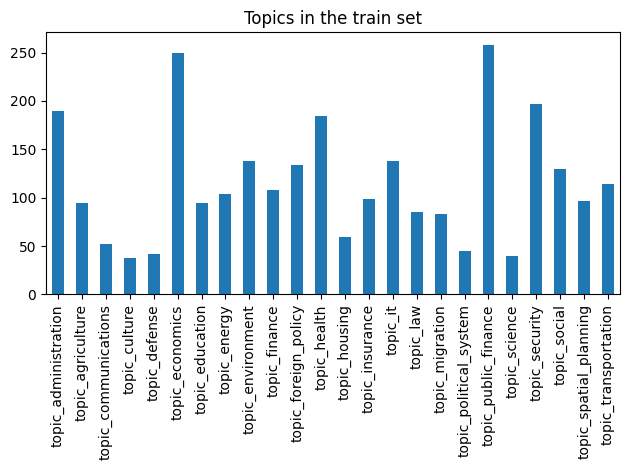

In [17]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "data/train_topic_counts.png",
    title="Topics in the train set",
)

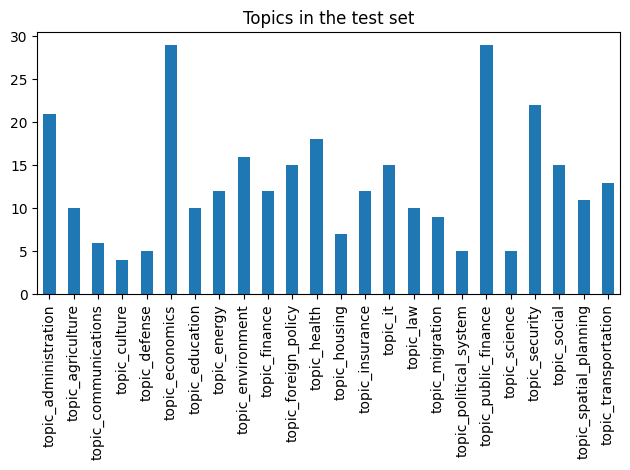

In [18]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "data/test_topic_counts.png",
    title="Topics in the test set",
)

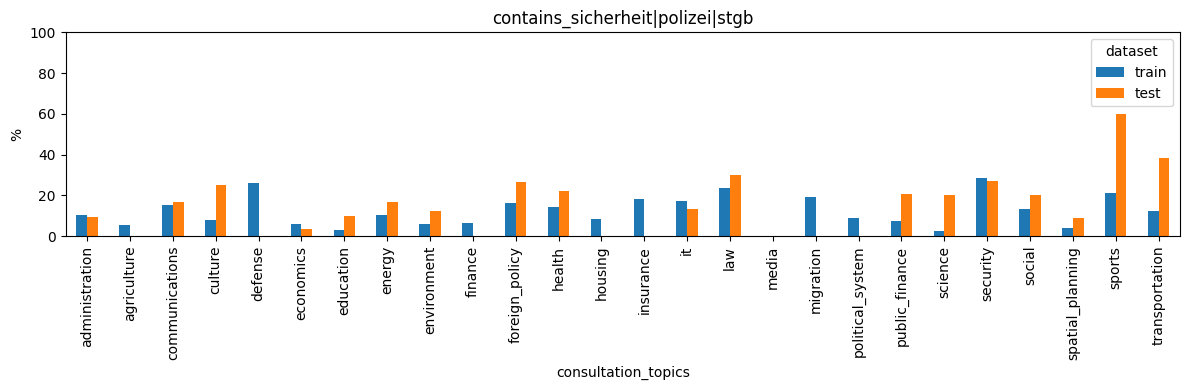

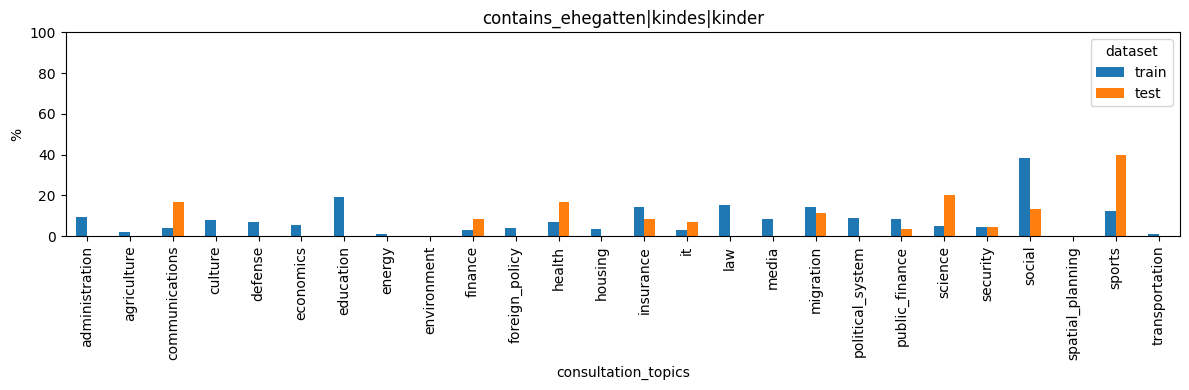

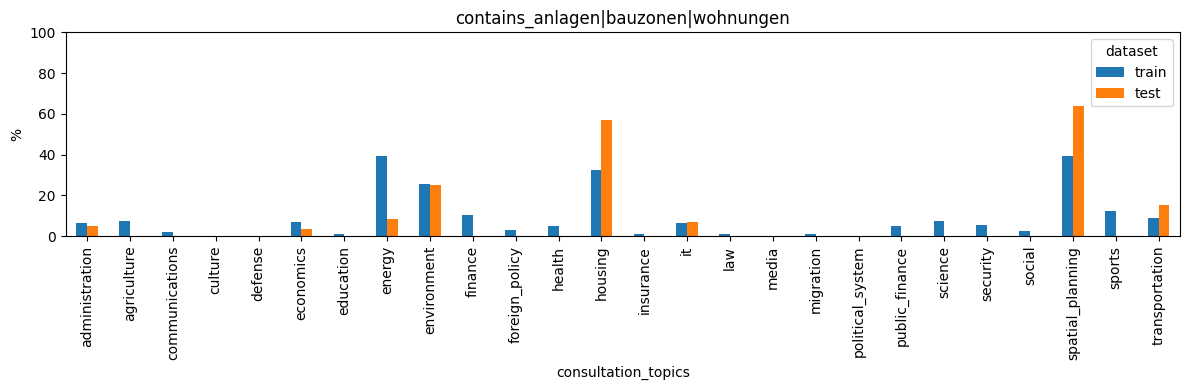

In [19]:
def plot_binary_feature_across_topics(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train.explode("consultation_topics")[["consultation_topics", feature_name]].assign(dataset="train"),
            df_test.explode("consultation_topics")[["consultation_topics", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="consultation_topics",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


for feature_name in KEYWORD_FEATURES:
    plot_binary_feature_across_topics(df_input_train, df_input_test, feature_name)
# plot_binary_feature_across_topics(df_input_train, df_input_test, "contains_sicherheit|polizei|stgb")

# Classification

In [ ]:
def create_matrices(df: pd.DataFrame) -> tuple[np.ndarray, pd.DataFrame]:
    x = np.hstack(
        [
            np.vstack(df["embedding_consultation_title"]),
            np.vstack(df["embedding_consultation_description"]),
            np.vstack(df["embedding_documents"]),
            df["organisation_uuid"].to_numpy().reshape(-1, 1),  # OneHotEncoder will handle this
            df[list(KEYWORD_FEATURES.keys())].to_numpy(),  # keyword features
        ]
    )
    y = df[topic_columns]
    assert x.shape[0] == y.shape[0]
    return x, y


def create_classifier(embedding_dimension: int, random_state: int) -> Pipeline:
    i_organisation_uuid = 3 * embedding_dimension
    i_keyword_features = i_organisation_uuid + 1

    return make_pipeline(
        ColumnTransformer(
            transformers=[
                (
                    "embeddings",
                    make_pipeline(
                        StandardScaler(),
                        PCA(n_components=450, random_state=random_state),
                    ),
                    slice(0, i_organisation_uuid),
                ),
                (
                    "organisation_uuid",
                    make_pipeline(
                        OneHotEncoder(handle_unknown="ignore"),
                        PCA(n_components=40, random_state=random_state),
                    ),
                    [i_organisation_uuid],
                ),
                (
                    "keyword_features",
                    "passthrough",
                    slice(i_keyword_features, i_keyword_features + len(KEYWORD_FEATURES)),
                ),
            ]
        ),
        MultiOutputClassifier(
            LogisticRegression(max_iter=1000),
        ),
    )


X_train, y_train = create_matrices(df_input_train)
X_test, y_test = create_matrices(df_input_test)

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (1100, 9220) (1100, 24)
Test (122, 9220) (122, 24)


## CV

In [21]:
classifier_cv = create_classifier(3072, RANDOM_STATE)
classifier_cv

,steps,"[('columntransformer', ...), ('multioutputclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('organisation_uuid', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
cv = iterstrat.ml_stratifiers.MultilabelStratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None, column_name: str = "") -> np.float64:
    """If PCA is used in the pipeline, include its explained variance in scores."""
    try:
        pca = pipeline.named_steps["columntransformer"].named_transformers_[column_name].named_steps["pca"]
    except (KeyError, AttributeError):
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


args = {
    "estimator": classifier_cv,
    "X": X_train,
    "y": y_train,
    "cv": cv,
    "verbose": 2,
    "n_jobs": -1,
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    **args,
    scoring={
        "precision": "precision_samples",
        "recall": "recall_samples",
        "f1": "f1_samples",
        **{
            f"pca_explained_variance_{c}": functools.partial(explained_variance_scorer, column_name=c)
            for c in (
                "embedding_consultation_title",
                "embedding_consultation_description",
                "embedding_documents",
                "organisation_uuid",
                "embeddings",
            )
        },
    },
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(**args)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[CV] END .................................................... total time=   4.1s
[CV] END .................................................... total time=   4.2s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=   4.0s
[CV] END .................................................... total time=   3.9s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


{'fit_time': array([4.05606484, 3.97880816, 4.10315633, 3.88683796, 3.8313179 ]),
 'score_time': array([0.14787793, 0.1406517 , 0.12544179, 0.12306881, 0.11533213]),
 'test_precision': array([0.81175595, 0.84159159, 0.79268477, 0.84431818, 0.8243349 ]),
 'test_recall': array([0.69642857, 0.71171171, 0.66063348, 0.6880303 , 0.65062598]),
 'test_f1': array([0.71366922, 0.74468039, 0.69551821, 0.72558442, 0.69883747]),
 'test_pca_explained_variance_embedding_consultation_title': array([nan, nan, nan, nan, nan]),
 'test_pca_explained_variance_embedding_consultation_description': array([nan, nan, nan, nan, nan]),
 'test_pca_explained_variance_embedding_documents': array([nan, nan, nan, nan, nan]),
 'test_pca_explained_variance_organisation_uuid': array([0.86527786, 0.86618602, 0.86643775, 0.87366026, 0.86302102]),
 'test_pca_explained_variance_embeddings': array([0.89778343, 0.89690933, 0.89759289, 0.89684445, 0.89634023])}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



cross_val_predict...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


In [23]:
utils.log_metrics(**{k.replace("test_", "cv_"): np.mean(v) for k, v in cv_scores.items() if k.startswith("test_")})

{'cv_f1': 0.7157,
 'cv_pca_explained_variance_embedding_consultation_description': nan,
 'cv_pca_explained_variance_embedding_consultation_title': nan,
 'cv_pca_explained_variance_embedding_documents': nan,
 'cv_pca_explained_variance_embeddings': 0.8971,
 'cv_pca_explained_variance_organisation_uuid': 0.8669,
 'cv_precision': 0.8229,
 'cv_recall': 0.6815}


cv_classification_report.txt

                        precision    recall  f1-score   support

  topic_administration       0.72      0.54      0.62       190
     topic_agriculture       0.86      0.86      0.86        94
  topic_communications       0.94      0.63      0.76        52
         topic_culture       0.94      0.45      0.61        38
         topic_defense       0.86      0.57      0.69        42
       topic_economics       0.63      0.53      0.58       250
       topic_education       0.92      0.78      0.84        94
          topic_energy       0.97      0.80      0.87       104
     topic_environment       0.84      0.75      0.79       138
         topic_finance       0.81      0.64      0.72       108
  topic_foreign_policy       0.77      0.63      0.69       134
          topic_health       0.89      0.77      0.82       184
         topic_housing       0.92      0.75      0.82        59
       topic_insurance       0.89      0.81      0.85        99
         

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


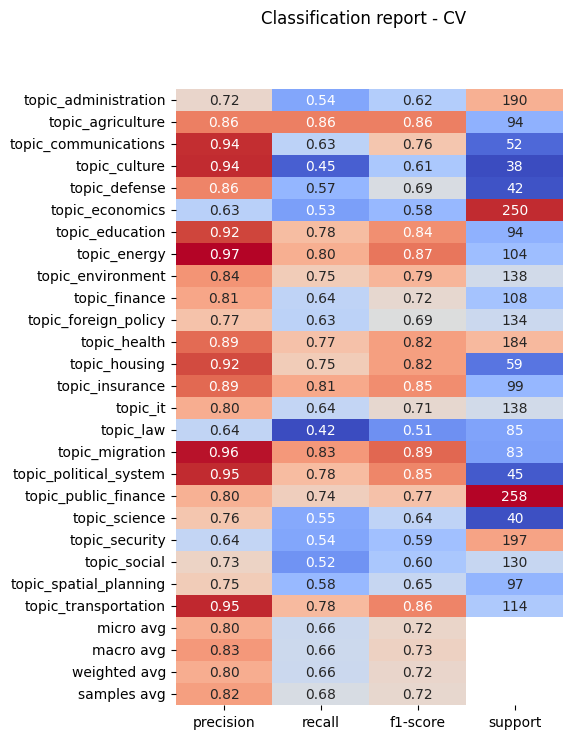

<Figure size 640x480 with 0 Axes>

In [24]:
utils.log_classification_report("cv", y_train, y_cv_predicted, target_names=topic_columns)
fig = plotting.plot_classification_report_heatmap(
    y_train.values,
    y_cv_predicted,
    target_names=topic_columns,
)
fig.suptitle("Classification report - CV")
plt.tight_layout()
mlflow.log_figure(fig, "cv_classification_report.png")
fig

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


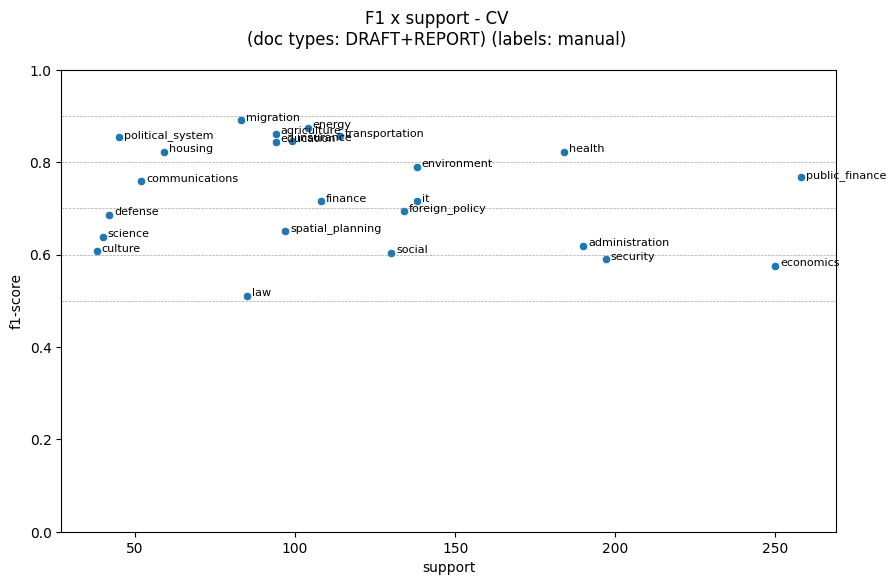

<Figure size 640x480 with 0 Axes>

In [25]:
fig = plotting.plot_score_against_support(
    y_train.values,
    y_cv_predicted,
    target_names=topic_columns,
)
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
# label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
label_sources = "+".join(sorted(TOPIC_LABEL_SOURCES))
fig.suptitle(
    "\n".join(
        [
            "F1 x support - CV",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
plt.tight_layout()
mlflow.log_figure(fig, "cv_score_against_support.png")
fig

In [26]:
report = pd.DataFrame(
    sklearn.metrics.classification_report(
        y_train.values,
        y_cv_predicted,
        target_names=topic_columns,
        output_dict=True,
        zero_division=np.nan,
    )
).transpose()["f1-score"]
# Print a dict of F1 scores for each topic that can be used for ignoring topics (in the Setup section)
{topic.replace("topic_", ""): round(f1, 3) for topic, f1 in report.items() if topic.startswith("topic_")}

{'administration': 0.619,
 'agriculture': 0.862,
 'communications': 0.759,
 'culture': 0.607,
 'defense': 0.686,
 'economics': 0.576,
 'education': 0.844,
 'energy': 0.874,
 'environment': 0.789,
 'finance': 0.715,
 'foreign_policy': 0.694,
 'health': 0.822,
 'housing': 0.822,
 'insurance': 0.847,
 'it': 0.715,
 'law': 0.511,
 'migration': 0.89,
 'political_system': 0.854,
 'public_finance': 0.767,
 'science': 0.638,
 'security': 0.59,
 'social': 0.604,
 'spatial_planning': 0.651,
 'transportation': 0.856}

## Training

2025/07/21 10:24:39 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2025/07/21 10:24:43 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/21 10:24:43 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/21 10:24:44 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/07/21 10:24:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


''

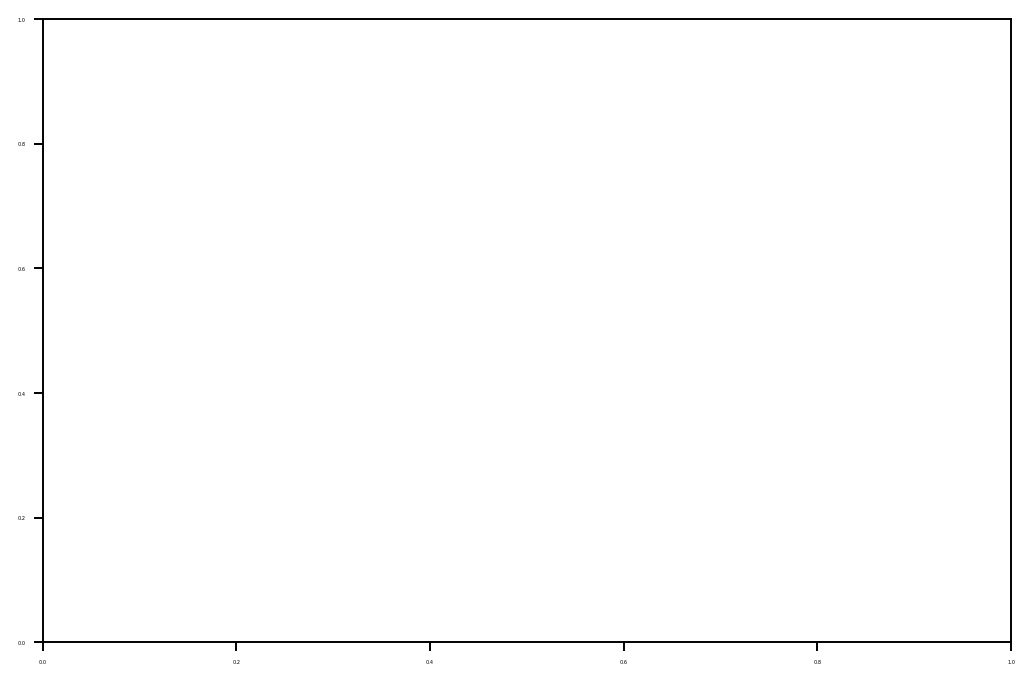

In [27]:
classifier_test = create_classifier(3072, RANDOM_STATE)
classifier_test.fit(X_train, y_train)
;

## Evaluation on the test set

In [28]:
y_test_predicted = classifier_test.predict(X_test)

precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test,
    y_test_predicted,
    average="samples",
    zero_division=np.nan,
)
test_scores = {"test_precision": precision, "test_recall": recall, "test_f1": f1}
utils.log_metrics(**test_scores)

{'test_f1': 0.7123, 'test_precision': 0.8256, 'test_recall': 0.6865}


test_classification_report.txt

                        precision    recall  f1-score   support

  topic_administration       0.69      0.52      0.59        21
     topic_agriculture       1.00      0.70      0.82        10
  topic_communications       0.60      0.50      0.55         6
         topic_culture       1.00      0.75      0.86         4
         topic_defense       1.00      0.60      0.75         5
       topic_economics       0.67      0.34      0.45        29
       topic_education       1.00      0.90      0.95        10
          topic_energy       1.00      1.00      1.00        12
     topic_environment       0.85      0.69      0.76        16
         topic_finance       0.67      0.50      0.57        12
  topic_foreign_policy       0.58      0.47      0.52        15
          topic_health       0.84      0.89      0.86        18
         topic_housing       0.57      0.57      0.57         7
       topic_insurance       0.92      0.92      0.92        12
       

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


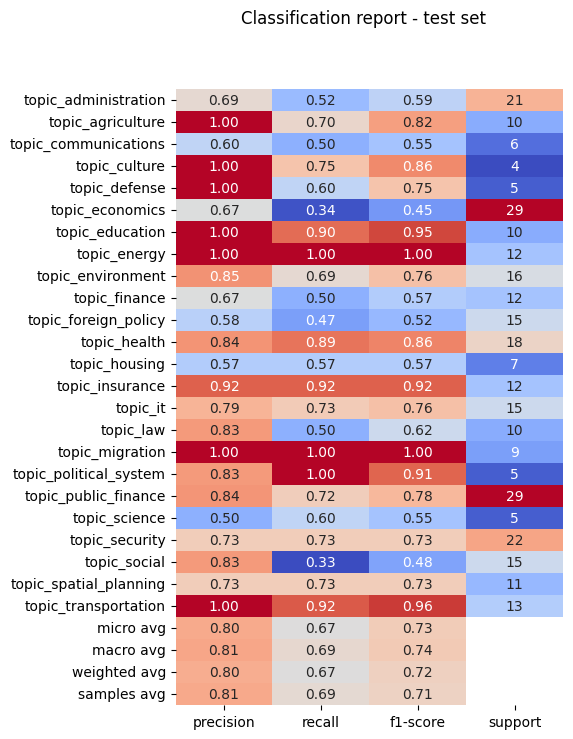

<Figure size 640x480 with 0 Axes>

In [29]:
utils.log_classification_report(
    "test",
    y_test,
    y_test_predicted,
    target_names=topic_columns,
)

fig = plotting.plot_classification_report_heatmap(
    y_test,
    y_test_predicted,
    target_names=topic_columns,
)
fig.suptitle("Classification report - test set")
mlflow.log_figure(fig, "test_classification_report.png")
plt.tight_layout()
display(fig)

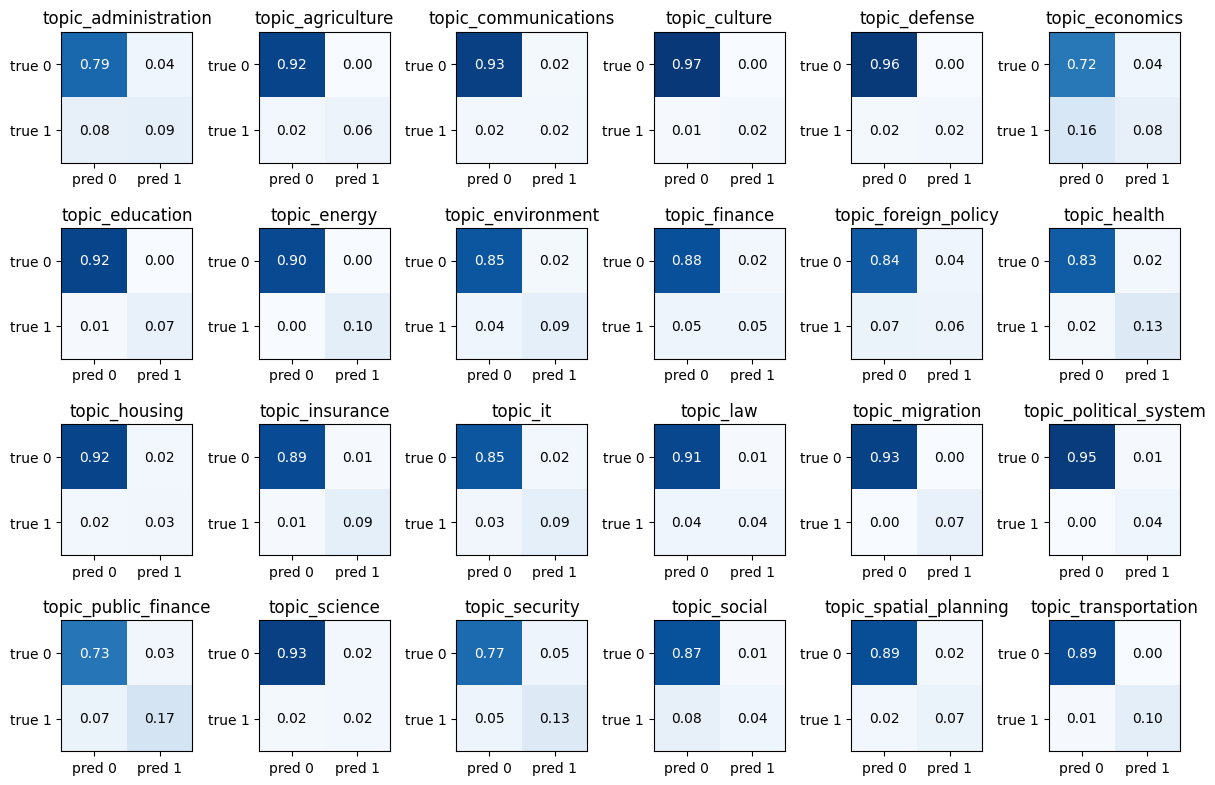

In [30]:
def plot_multilabel_confusion_matrices(Y_true: np.ndarray, Y_pred: np.ndarray, class_names: list[str]) -> None:
    """
    Plot confusion matrices (2x2) for each label as heatmaps.
    """
    cm_list = sklearn.metrics.multilabel_confusion_matrix(Y_true, Y_pred)
    n_classes = len(class_names)
    n_cols = 6
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, (cm, label) in enumerate(zip(cm_list, class_names, strict=True)):
        cm = cm / cm.sum()  # noqa: PLW2901
        # assert cm.sum() == 1.0

        ax = axes[i]
        ax.imshow(cm, interpolation="nearest", cmap="Blues", vmin=0, vmax=1)
        ax.set_title(label)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["pred 0", "pred 1"])
        ax.set_yticklabels(["true 0", "true 1"])

        # Annotate cells
        thresh = cm.max() / 2.0
        for j in range(2):
            for k in range(2):
                ax.text(
                    k,
                    j,
                    format(cm[j, k], ".2f"),
                    ha="center",
                    va="center",
                    color="white" if cm[j, k] > thresh else "black",
                )

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    plt.show()


plot_multilabel_confusion_matrices(y_test, y_test_predicted, class_names=topic_columns)

***

# End MLflow run

In [31]:
mlflow.end_run()

🏃 View run brawny-crane-117 at: https://mlflow.ml1.demokratis.ch/#/experiments/7/runs/f1e344ca105a446c8d96d848b53189e4
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/7


***

# Cleanlab

In [32]:
RUN_CLEANLAB = False

In [33]:
import cleanlab
import cleanlab.internal.multilabel_utils

from research.lib import cleanlab_analysis

if RUN_CLEANLAB:
    df_cleanlab = pd.concat([df_input_train, df_input_test], ignore_index=True)
    X_cleanlab, y_cleanlab = create_matrices(df_cleanlab)
    print(X_cleanlab.shape)
    classifier_cleanlab = create_classifier(RANDOM_STATE)
    pred_probs_list = sklearn.model_selection.cross_val_predict(
        estimator=classifier_cleanlab,
        X=X_cleanlab,
        y=y_cleanlab,
        groups=df_cleanlab["consultation_identifier"],
        cv=cv,
        method="predict_proba",
        n_jobs=-1,
        verbose=2,
    )
    # Extract the positive class probabilities
    positive_probs = [proba[:, 1] for proba in pred_probs_list]
    # Stack into a (n_samples, n_classes) array
    pred_probs = np.column_stack(positive_probs)
    print(pred_probs.shape)
    assert pred_probs.shape[0] == len(df_cleanlab)
    assert pred_probs.shape[1] == len(topic_columns)

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
if RUN_CLEANLAB:
    labels = cleanlab.internal.multilabel_utils.onehot2int(y_cleanlab.values)
    lab = cleanlab.Datalab(
        data={
            "X": X_cleanlab,
            "labels": labels,
        },
        label_name="labels",
        task="multilabel",
    )
    lab.find_issues(pred_probs=pred_probs, features=X_cleanlab)
    lab.report()

In [35]:
if RUN_CLEANLAB:
    df_output = df_cleanlab.copy()
    df_output["consultation_url"] = df_output.apply(
        lambda d: f"https://www.demokratis.ch/vernehmlassung/{d['consultation_identifier']}",
        axis=1,
    )
    df_output["document_url"] = df_output.apply(
        lambda d: f"https://www.demokratis.ch/vernehmlassung/{d['consultation_identifier']}/dokument/{d['document_uuid']}"
        if d["document_uuid"]
        else "",
        axis=1,
    )
    # df_output["edit_link"] = df_output.apply(
    #     lambda d: f"https://www.demokratis.ch/de/consultation/{d['consultation_identifier']}/admin/document/{d['document_uuid']}/edit",
    #     axis=1,
    # )
    df_output = df_output[
        [
            "consultation_identifier",
            "consultation_url",
            "document_url",
            "document_uuid",
            "document_type",
        ]
    ]
    true_labels = y_cleanlab.copy()
    true_labels.columns = [c.replace("topic_", "") for c in true_labels.columns]
    issue_dfs = cleanlab_analysis.cleanlab_issues_to_excel(
        lab,
        pred_probs=pred_probs,
        dataset=df_output,
        multilabel_true_labels=true_labels,
        output_path=f"cleanlab_issues_{DATA_VERSION}.xlsx",
        linkify_columns={
            # "edit_link",
            "consultation_url",
            "document_url",
            # "document_source_url",  # Odd characters in some URLs cause Excel errors
        },
        issue_types=(
            "label",
            "near_duplicate",
            "outlier",
            # "underperforming_group",
            "non_iid",
        ),
    )

In [36]:
if RUN_CLEANLAB:
    display(issue_dfs["label"]["document_type"].value_counts())